## Import Libraries

In [94]:
import cv2 
import pickle
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import glob

In [95]:
import os
os.chdir('/Users/kerengranov/Desktop/KerenO')  
os.getcwd()

'/Users/kerengranov/Desktop/KerenO'

### Functions

In [113]:



#The keypoints are generated on the grayscale images
def imagesBW(imageList):
    images_BW = []
    for imageName in imageList:
        imagePath = "data/images/" + str(imageName)
        #print(imagePath)
        images_BW.append(imageResize(cv2.imread(imagePath,0)))
    return images_BW

#all images are being resized so we will focus on relevant keypoints
def imageResize(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

#all images are being resized so we will focus on relevant keypoints
def imageResizeBW(image):
    maxD = 1024
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image


def computeSIFT(image):
    sift = cv2.xfeatures2d.SIFT_create()
    return sift.detectAndCompute(image, None)

    
#compute keypoints and descriptors based on sift
#we save them, so we will be able to use the results in a loop without computing every time
def keypoints_descriptors(imageList):
    images_BW=imagesBW(imageList)
    keypoints = []
    descriptors = []
    i = 0
    for image in images_BW:
        keypointTemp, descriptorTemp = computeSIFT(image)
        keypoints.append(keypointTemp)
        descriptors.append(descriptorTemp)
        i += 1

    i = 0
    for keypoint in keypoints:
        deserializedKeypoints = []
        filepath = "data/keypoints/" + str(imageList[i].split('.')[0]) + ".txt"
        for point in keypoint:
            temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
            deserializedKeypoints.append(temp)
        with open(filepath, 'wb') as fp:
            pickle.dump(deserializedKeypoints, fp)    
        i += 1


    i = 0
    for descriptor in descriptors:
        filepath = "data/descriptors/" + str(imageList[i].split('.')[0]) + ".txt"
        with open(filepath, 'wb') as fp:
            pickle.dump(descriptor, fp)
        i += 1

def fetchKeypointFromFile(i):
    filepath = "data/keypoints/" + str(imageList[i].split('.')[0]) + ".txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(x=point[0][0],y=point[0][1],_size=point[1], _angle=point[2], _response=point[3], _octave=point[4], _class_id=point[5])
        keypoint.append(temp)
    return keypoint

def fetchDescriptorFromFile(i):
    filepath = "data/descriptors/" + str(imageList[i].split('.')[0]) + ".txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

#calculating the basic matching score for 2 specific images
def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

# Calculating the Results for any pair
def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches(descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    return(score, plot)

def showplot(plot):
    plt.imshow(plot),plt.show()


def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResizeBW(cv2.imread("data/images/" + imageList[i]))
    image2 = imageResizeBW(cv2.imread("data/images/" + imageList[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

#resize the images for the gui
def changeImageSize(i, basewidth=90):
    img = Image.open("data/images/" + imageList[i])
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    return img

#resize and save the pairs with the relevant name
def pairOutput(i,j,pair_num):
    image1 = changeImageSize(i)
    image2 = changeImageSize(j)
    new_i = image1    
    new_j = image2
    showplot(image1)
    showplot(image2)
    image1.save("data/results/pair" + str(pair_num) +"_1.jpeg")
    image2.save("data/results/pair" + str(pair_num) +"_2.jpeg")
    return (image1,image2)


#  matching descriptors by knn 
def calculateMatches(des1,des2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    topResults1 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults1.append([m])
            
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults2.append([m])
    
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults


def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(image1,keypoint1,image2,keypoint2,matches,None,[255,255,255],flags=2)
    return matchPlot

#building the score matrix
def scores_matrix(imageList):
    length = len(imageList)
    scores = np.zeros([length,length])
    for i in range(length):
        for j in range(i):
           # print("i: ",i,"j: ", j)
            score,plot=calculateResultsFor(i,j)
            scores[i,j] = score
    scores=scores.tolist()
    return scores

#finding all posible pairs
def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest
                
                
#compare the score of all pairs' combinations
def find_best_pairs(imageList):
    images_len=len(imageList)
    images_len_list = list(range(images_len))
    all_comb_scores=[]
    combinations = all_pairs(images_len_list)
    for combination in combinations:
        combination_score=0
       # print(combination)
        for pair in combination:
            pair_score = (scores[pair[0]][pair[1]]+scores[pair[1]][pair[0]])
        #    print(pair)   
            combination_score+=pair_score
        all_comb_scores.append(combination_score)
       # print(all_comb_scores)

    best_pairs_index=all_comb_scores.index(max(all_comb_scores))

    combinations = all_pairs(images_len_list)

    for combination_num, combination in enumerate(combinations):

        if combination_num==best_pairs_index:
            print(combination_num)
            print(combination)
            for pair_num,pair in enumerate(combination):
                score, plot=calculateResultsFor(pair[0],pair[1])     
                print("score: ", score)
                showplot(plot)
                pairOutput(pair[0],pair[1],pair_num)
                


### Main

0
[(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11)]
score:  13.240043057050594


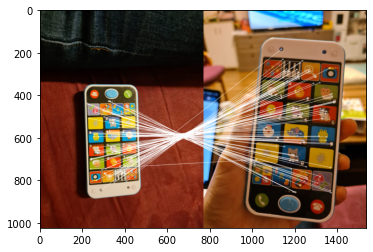

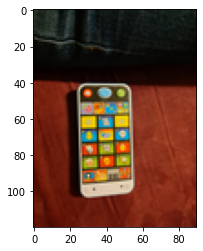

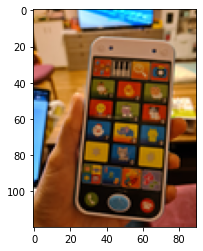

score:  0.30303030303030304


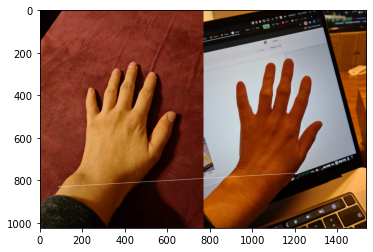

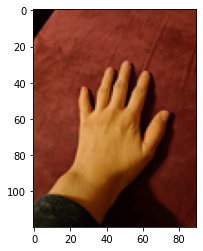

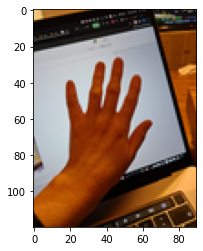

score:  0.9885419006964726


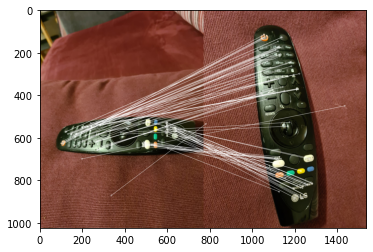

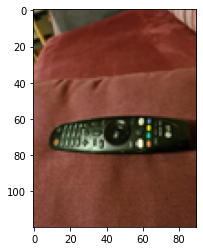

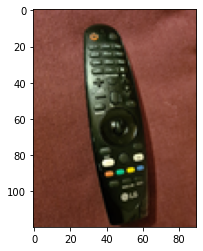

score:  9.044715447154472


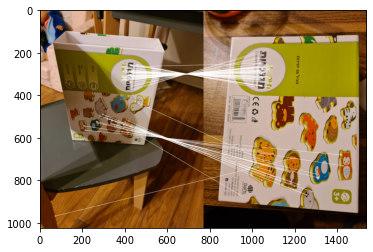

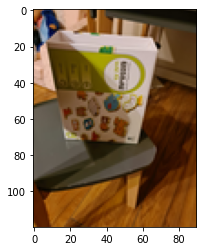

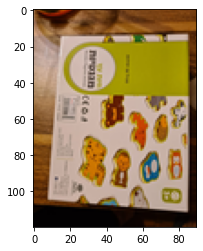

score:  8.928571428571429


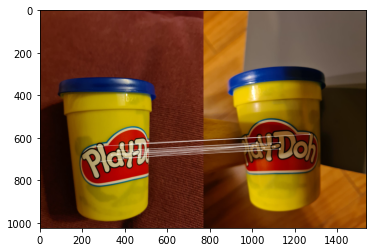

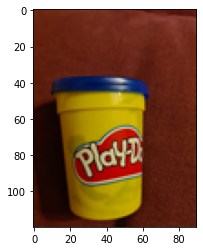

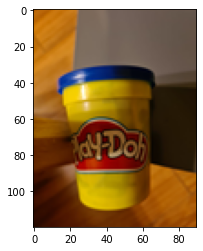

score:  6.772536198038299


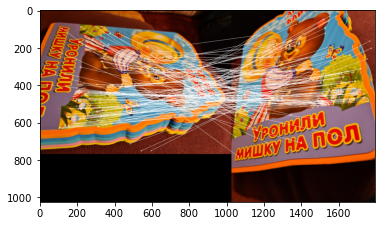

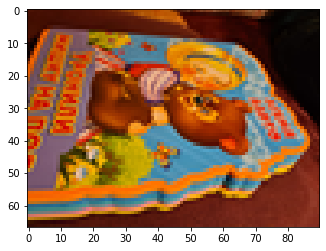

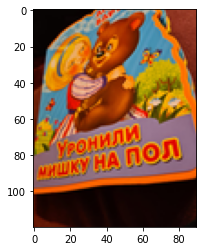

In [114]:
removeOldResults()

# Define a list of images the way you like
imageList = ["phone1.jpeg","phone2.jpeg","hand1.jpeg",
             "hand2.jpeg","remote1.jpeg","remote2.jpeg",
             "puzzle2.jpeg","puzzle1.jpeg","doh2.jpeg","doh1.jpeg","book_ru2.jpeg","book_ru1.jpeg"]#,"taj1.jpeg","taj2.jpeg","eiffel1.jpeg",
             #"eiffel2.jpeg","liberty1.jpeg","liberty2.jpeg",
             #"ironman1.jpeg","ironman2.jpeg"]#,"darkknight1.jpeg","darkknight2.jpeg","book1.jpeg","book2.jpeg"]
keypoints_descriptors(imageList)
scores = scores_matrix(imageList)
find_best_pairs(imageList)
